# Unleash the Ray - Grid Search

Let's revisit our grid search example but now with Ray

A lot of this code is going to be familiar as we already had our pipeline wraped in a function

In [6]:
%load_ext autoreload
%autoreload 2

from dependencies import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import ray
from ray import tune

### Let's start Ray

In [11]:
ray.shutdown()
ray.init(num_cpus=10, num_gpus=0, include_webui=True)

2020-06-11 12:10:40,472	INFO resource_spec.py:204 -- Starting Ray with 35.01 GiB memory available for workers and up to 17.53 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-11 12:10:40,725	INFO services.py:1168 -- View the Ray dashboard at localhost:8266


{'node_ip_address': '192.168.1.39',
 'raylet_ip_address': '192.168.1.39',
 'redis_address': '192.168.1.39:35395',
 'object_store_address': '/tmp/ray/session_2020-06-11_12-10-40_471170_38101/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-11_12-10-40_471170_38101/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2020-06-11_12-10-40_471170_38101'}

After initialisation the [Ray Dashboard](https://docs.ray.io/en/master/ray-dashboard.html) is available on the **webui_url** port

## Setup some raytune compatible training code

Very similar to before except now we have an end-to-end function

In [13]:

# differences from what we've seen before, this is an end to end training function
# where we are loading the dataset running our complete train and test loop whilst
# 
def e2e_simple_training(config):
    
    #threadsafe
    X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
    
    # chose your CV strategy
    splitter = StratifiedKFold(n_splits=5)
    
    # run k fold training and testing
    f1_scores = [] # keep hold of all individual scores
    for train_ind, test_ind in splitter.split(X, y):
        pipeline = make_pipeline(RobustScaler(),
                                  RandomForestClassifier(random_state=42))

        pipeline.set_params(**config)
        pipeline.fit(X[train_ind], y[train_ind])
        
        y_pred = pipeline.predict(X[test_ind])
        
        f1_scores.append(f1_score(y_pred, y[test_ind]))
    
    # use tunes reporter
    tune.track.log(mean_f1_score=np.array(f1_scores).mean(),
                std_f1_score=np.array(f1_scores).std(),
                # and we can actually add any metrics we like
                done=True)

Previously we had a param grid like this

```
param_grid = {
    'randomforestclassifier__n_estimators': [1,5,15,50,100],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__bootstrap': [True, False]
}
```

### TODO convert this to a set of ray search spaces

The Ray config object is freeform, we imprint our own structure.

However, tunable parameters need to be represented by tune distribution object >> [read the docs](https://docs.ray.io/en/latest/tune/api_docs/grid_random.html?highlight=tune.grid#random-distributions-api)

In [14]:
ray_tuning_config = {
    'randomforestclassifier__n_estimators': tune.grid_search([1,5,15,50,100])
}

In [15]:
analysis = tune.run(
                e2e_simple_training,
                config=ray_tuning_config,
                resources_per_trial=dict(cpu=1, gpu=0),
                local_dir="~/ray_results/grid_search")

Trial name,status,loc,randomforestclassifier__n_estimators
e2e_simple_training_00000,RUNNING,,1
e2e_simple_training_00001,PENDING,,5
e2e_simple_training_00002,PENDING,,15
e2e_simple_training_00003,PENDING,,50
e2e_simple_training_00004,PENDING,,100


(pid=55412) 2020-06-11 12:11:45,284	INFO trainable.py:217 -- Getting current IP.
(pid=55418) 2020-06-11 12:11:45,311	INFO trainable.py:217 -- Getting current IP.
(pid=55415) 2020-06-11 12:11:45,311	INFO trainable.py:217 -- Getting current IP.
(pid=55419) 2020-06-11 12:11:45,299	INFO trainable.py:217 -- Getting current IP.
(pid=55414) 2020-06-11 12:11:45,305	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00000:
  date: 2020-06-11_12-11-45
  done: true
  experiment_id: 602274e273d1406da9197b75e1322dc1
  experiment_tag: 0_randomforestclassifier__n_estimators=1
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9267873910127431
  node_ip: 192.168.1.39
  pid: 55412
  std_f1_score: 0.022471880003588674
  time_since_restore: 0.05721163749694824
  time_this_iter_s: 0.05721163749694824
  time_total_s: 0.05721163749694824
  timestamp: 1591873905
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00000'
  
Result for e2e_simple_train

Trial name,status,loc,randomforestclassifier__n_estimators,iter,total time (s)
e2e_simple_training_00000,TERMINATED,,1,0,0.0572116
e2e_simple_training_00001,TERMINATED,,5,0,0.126387
e2e_simple_training_00002,TERMINATED,,15,0,0.200779
e2e_simple_training_00003,TERMINATED,,50,0,0.510976
e2e_simple_training_00004,TERMINATED,,100,0,0.896334


In [16]:
df = analysis.dataframe()
print(df.columns)
df.head()

Index(['mean_f1_score', 'std_f1_score', 'done', 'trial_id',
       'training_iteration', 'time_this_iter_s', 'timesteps_total',
       'episodes_total', 'experiment_id', 'date', 'timestamp', 'time_total_s',
       'pid', 'hostname', 'node_ip', 'time_since_restore',
       'timesteps_since_restore', 'iterations_since_restore', 'experiment_tag',
       'config/randomforestclassifier__n_estimators', 'logdir'],
      dtype='object')


,mean_f1_score,std_f1_score,done,trial_id,training_iteration,time_this_iter_s,timesteps_total,episodes_total,experiment_id,date,...,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config/randomforestclassifier__n_estimators,logdir
0,0.926787,0.022472,True,0,0,0.057212,NaN,NaN,602274e273d1406da9197b75e1322dc1,2020-06-11_12-11-45,...,0.057212,55412,cosmos-ml,192.168.1.39,0.057212,0,1,0_randomforestclassifier__n_estimators=1,1,/home/steve/ray_results/grid_search/e2e_simple...
1,0.960576,0.028015,True,1,0,0.126387,NaN,NaN,e7ef4d4efe2e4dccaa6977700df95bf2,2020-06-11_12-11-45,...,0.126387,55414,cosmos-ml,192.168.1.39,0.126387,0,1,1_randomforestclassifier__n_estimators=5,5,/home/steve/ray_results/grid_search/e2e_simple...
2,0.963828,0.021657,True,2,0,0.200779,NaN,NaN,e1e0850e629c47d1a9662519b0ebd290,2020-06-11_12-11-45,...,0.200779,55415,cosmos-ml,192.168.1.39,0.200779,0,1,2_randomforestclassifier__n_estimators=15,15,/home/steve/ray_results/grid_search/e2e_simple...
3,0.963645,0.019522,True,3,0,0.510976,NaN,NaN,6a1625a97b63407fa6b48c1cb6e73363,2020-06-11_12-11-45,...,0.510976,55419,cosmos-ml,192.168.1.39,0.510976,0,1,3_randomforestclassifier__n_estimators=50,50,/home/steve/ray_results/grid_search/e2e_simple...
4,0.965198,0.018341,True,4,0,0.896334,NaN,NaN,3bcc34ba8fa945168a64caaba6273a46,2020-06-11_12-11-46,...,0.896334,55418,cosmos-ml,192.168.1.39,0.896334,0,1,4_randomforestclassifier__n_estimators=100,100,/home/steve/ray_results/grid_search/e2e_simple...


In [17]:
print("Best config: ", analysis.get_best_config(metric="mean_f1_score"))

Best config:  {'randomforestclassifier__n_estimators': 100}


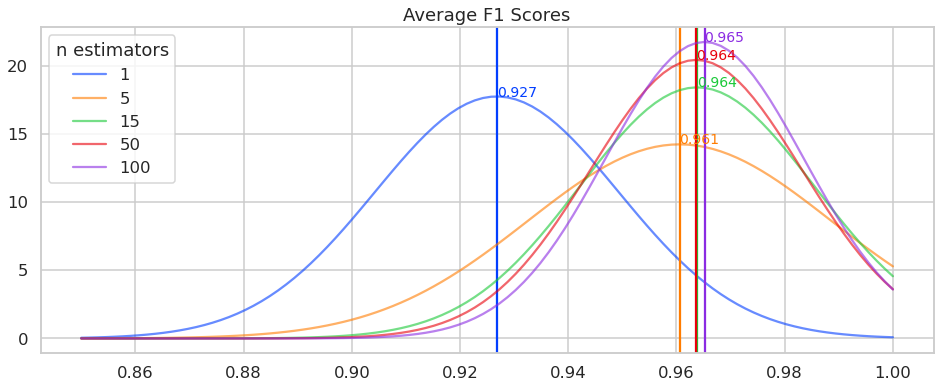

In [18]:
from scipy.stats import norm

def plot_some_tune_results(df):
    fig, ax = plt.subplots(1, 1, figsize=(16,6))
    x = np.linspace(0.85, 1.0, 100)

    n_estimators = df['config/randomforestclassifier__n_estimators'].values.tolist()

    lines = []
    for mu, sigma in zip(df['mean_f1_score'], df['std_f1_score']):
        pdf = norm.pdf(x, mu, sigma)
        line, = ax.plot(x, pdf, alpha=0.6)
        ax.axvline(mu, color=line.get_color())
        ax.text(mu, pdf.max(), f"{mu:.3f}", color=line.get_color(), fontsize=14)
        lines.append(line)

    plt.legend(handles=lines, labels=n_estimators, title="n estimators")
    ax.set_title(f"Average F1 Scores")
    
plot_some_tune_results(df)

## Really increase the size of the search space

In [19]:
#
# 6D search space - 960 combinations - 4800 calls to fit
#

ray_tuning_config = {
    'randomforestclassifier__n_estimators': tune.grid_search([1,5,15,50,100]),
    'randomforestclassifier__criterion': tune.grid_search(['gini', 'entropy']),
    'randomforestclassifier__max_features': tune.grid_search(['auto', 'sqrt', 'log2']),
#     'randomforestclassifier__bootstrap': tune.grid_search([True, False]),
#     'randomforestclassifier__min_samples_leaf': tune.grid_search([1,2,3,4]),
#     'randomforestclassifier__min_samples_split': tune.grid_search([3,4,5,6])
}

In [20]:
analysis = tune.run(
                e2e_simple_training,
                config=ray_tuning_config,
                resources_per_trial=dict(cpu=1, gpu=0)
                )

Trial name,status,loc,randomforestclassifier__criterion,randomforestclassifier__max_features,randomforestclassifier__n_estimators
e2e_simple_training_00001,PENDING,,entropy,auto,1
e2e_simple_training_00002,PENDING,,gini,sqrt,1
e2e_simple_training_00003,PENDING,,entropy,sqrt,1
e2e_simple_training_00004,PENDING,,gini,log2,1
e2e_simple_training_00005,PENDING,,entropy,log2,1
e2e_simple_training_00006,PENDING,,gini,auto,5
e2e_simple_training_00007,PENDING,,entropy,auto,5
e2e_simple_training_00008,PENDING,,gini,sqrt,5
e2e_simple_training_00009,PENDING,,entropy,sqrt,5
e2e_simple_training_00010,PENDING,,gini,log2,5


(pid=55423) 2020-06-11 12:12:24,022	INFO trainable.py:217 -- Getting current IP.
(pid=55417) 2020-06-11 12:12:24,053	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00001:
  date: 2020-06-11_12-12-24
  done: true
  experiment_id: 135b22fd43524b6880e7dd0b50d9db18
  experiment_tag: 1_randomforestclassifier__criterion=entropy,randomforestclassifier__max_features=auto,randomforestclassifier__n_estimators=1
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9383032529434383
  node_ip: 192.168.1.39
  pid: 55423
  std_f1_score: 0.018497010432318915
  time_since_restore: 0.10036420822143555
  time_this_iter_s: 0.10036420822143555
  time_total_s: 0.10036420822143555
  timestamp: 1591873944
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00001'
  
(pid=55420) 2020-06-11 12:12:24,148	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00000:
  date: 2020-06-11_12-12-24
  done: true
  experiment_id: be4d04fc3

(pid=55700) 2020-06-11 12:12:25,648	INFO trainable.py:217 -- Getting current IP.
(pid=55652) 2020-06-11 12:12:25,674	INFO trainable.py:217 -- Getting current IP.
(pid=55710) 2020-06-11 12:12:25,806	INFO trainable.py:217 -- Getting current IP.
Result for e2e_simple_training_00014:
  date: 2020-06-11_12-12-25
  done: true
  experiment_id: 4825f715846c4df5b92139ff4b52575c
  experiment_tag: 14_randomforestclassifier__criterion=gini,randomforestclassifier__max_features=sqrt,randomforestclassifier__n_estimators=15
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9638277663479424
  node_ip: 192.168.1.39
  pid: 55649
  std_f1_score: 0.021657029005996857
  time_since_restore: 0.44782018661499023
  time_this_iter_s: 0.44782018661499023
  time_total_s: 0.44782018661499023
  timestamp: 1591873945
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00014'
  
(pid=55668) 2020-06-11 12:12:25,849	INFO trainable.py:217 -- Getting current IP.
(pid=55660) 2020-06-11 12

Trial name,status,loc,randomforestclassifier__criterion,randomforestclassifier__max_features,randomforestclassifier__n_estimators,iter,total time (s)
e2e_simple_training_00028,RUNNING,,gini,log2,100,,
e2e_simple_training_00029,RUNNING,,entropy,log2,100,,
e2e_simple_training_00000,TERMINATED,,gini,auto,1,0,0.0875349
e2e_simple_training_00001,TERMINATED,,entropy,auto,1,0,0.100364
e2e_simple_training_00002,TERMINATED,,gini,sqrt,1,0,0.183042
e2e_simple_training_00003,TERMINATED,,entropy,sqrt,1,0,0.172172
e2e_simple_training_00004,TERMINATED,,gini,log2,1,0,0.206887
e2e_simple_training_00005,TERMINATED,,entropy,log2,1,0,0.0891452
e2e_simple_training_00006,TERMINATED,,gini,auto,5,0,0.141039
e2e_simple_training_00007,TERMINATED,,entropy,auto,5,0,0.121226


Result for e2e_simple_training_00028:
  date: 2020-06-11_12-12-28
  done: true
  experiment_id: 4d459959b7bd4ec08f176977063a0b31
  experiment_tag: 28_randomforestclassifier__criterion=gini,randomforestclassifier__max_features=log2,randomforestclassifier__n_estimators=100
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9679820350661037
  node_ip: 192.168.1.39
  pid: 55897
  std_f1_score: 0.014463142278844264
  time_since_restore: 0.9178991317749023
  time_this_iter_s: 0.9178991317749023
  time_total_s: 0.9178991317749023
  timestamp: 1591873948
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 00028
  
Result for e2e_simple_training_00029:
  date: 2020-06-11_12-12-28
  done: true
  experiment_id: 3e0d0bd6ae4e4757947d4c5dd3c6677d
  experiment_tag: 29_randomforestclassifier__criterion=entropy,randomforestclassifier__max_features=log2,randomforestclassifier__n_estimators=100
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.9693186

Trial name,status,loc,randomforestclassifier__criterion,randomforestclassifier__max_features,randomforestclassifier__n_estimators,iter,total time (s)
e2e_simple_training_00000,TERMINATED,,gini,auto,1,0,0.0875349
e2e_simple_training_00001,TERMINATED,,entropy,auto,1,0,0.100364
e2e_simple_training_00002,TERMINATED,,gini,sqrt,1,0,0.183042
e2e_simple_training_00003,TERMINATED,,entropy,sqrt,1,0,0.172172
e2e_simple_training_00004,TERMINATED,,gini,log2,1,0,0.206887
e2e_simple_training_00005,TERMINATED,,entropy,log2,1,0,0.0891452
e2e_simple_training_00006,TERMINATED,,gini,auto,5,0,0.141039
e2e_simple_training_00007,TERMINATED,,entropy,auto,5,0,0.121226
e2e_simple_training_00008,TERMINATED,,gini,sqrt,5,0,0.131577
e2e_simple_training_00009,TERMINATED,,entropy,sqrt,5,0,0.116725


In [23]:
from pprint import pprint
print("Best config: ")
pprint(analysis.get_best_config(metric="mean_f1_score"))

Best config: 
{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__n_estimators': 50}


In [24]:
df = analysis.dataframe()
top_n_df = df.nlargest(10, "mean_f1_score")

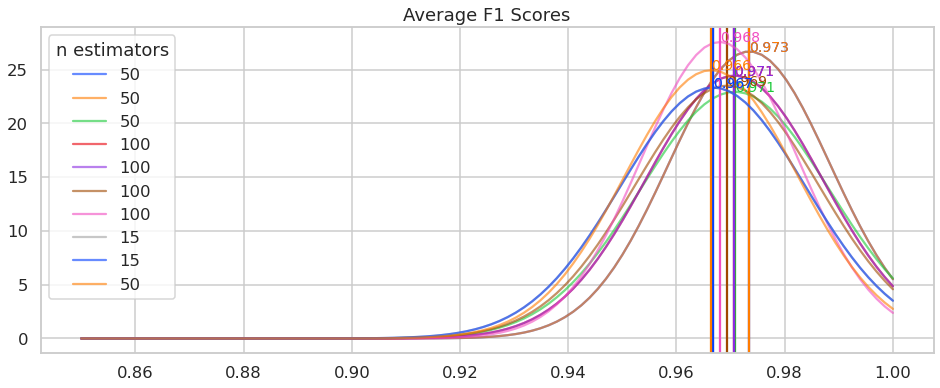

In [25]:
plot_some_tune_results(top_n_df)

In [27]:
%load_ext tensorboard

In [29]:
from tensorboard import notebook
%tensorboard --logdir "~/ray_results/grid_search"
notebook.display(height=1000) 

Selecting TensorBoard with logdir ~/ray_results/grid_search (started 0:00:00 ago; port 6006, pid 56090).


### Once you are all done, shutdown Ray

In [ ]:
ray.shutdown()